
Shape: (5000, 2)
/n FIRST 10 DATA RECORDS:                                             sentence  contains_bad_word
0                                  you fuck your dad                  1
1  i really do not understand your point it seems...                  0
2  a majority of canadians can and has been wrong...                  0
3  listen if you dont wanna get married to a man ...                  0
4  ok but i would hope they would sign him to a o...                  0
5                         yeah and where are you now                  0
6  shut the fuck up you and the rest of your fagg...                  1
7  either you are fake or extremely stupid maybe ...                  1
8  that you are an idiot who understands neither ...                  1
9   dan siapapun yang pro pemerintah langsung dic...                  1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------

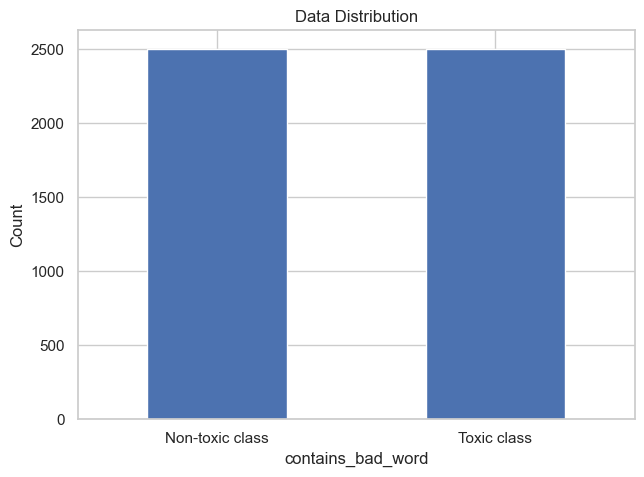

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 100)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 100, 64)           522880    
                                                                 
 bidirectional (Bidirection  (None, 100, 128)          66048     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

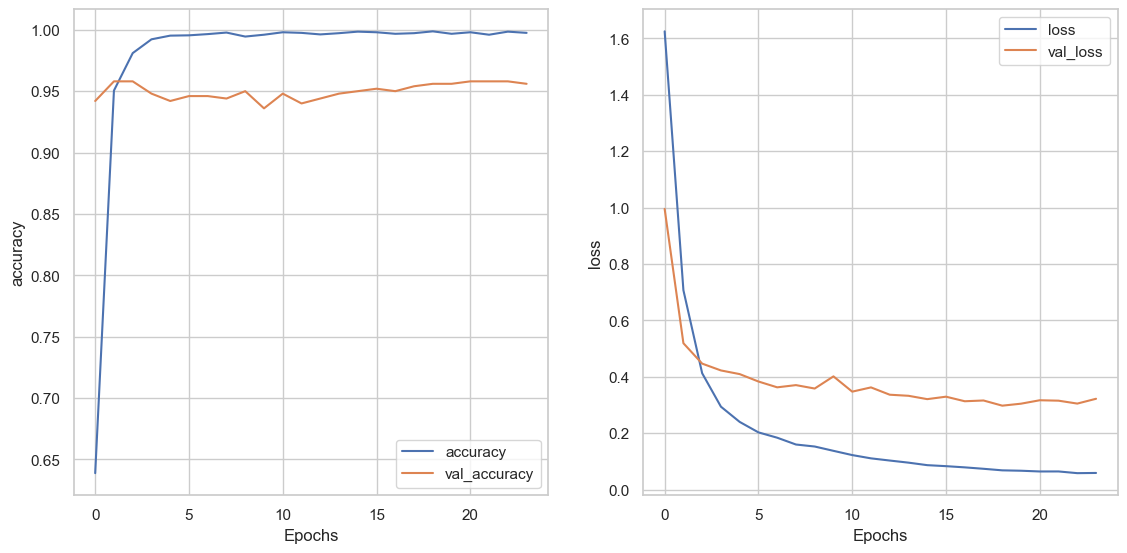

8/8 [==============================] - 6s 58ms/step
Accuracy: 0.956
Precision: 0.9533898305084746
Recall: 0.9533898305084746
F1-score: 0.9533898305084746
F1-score: 0.9533898305084746
Unique values in validation labels: [False  True]
Unique values in validation predictions: [0 1]


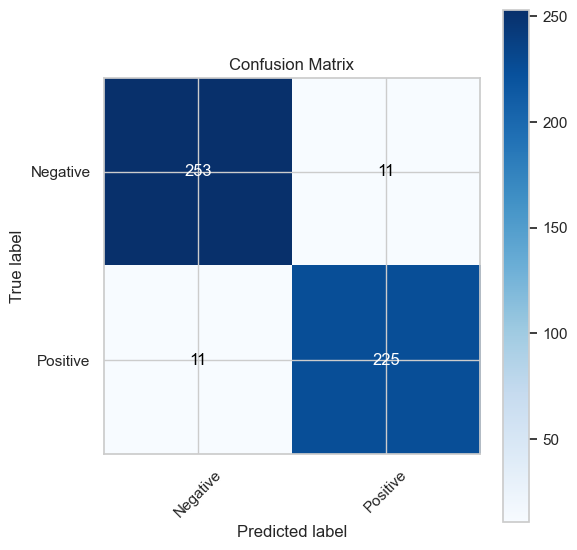

8/8 [==============================] - 1s 60ms/step


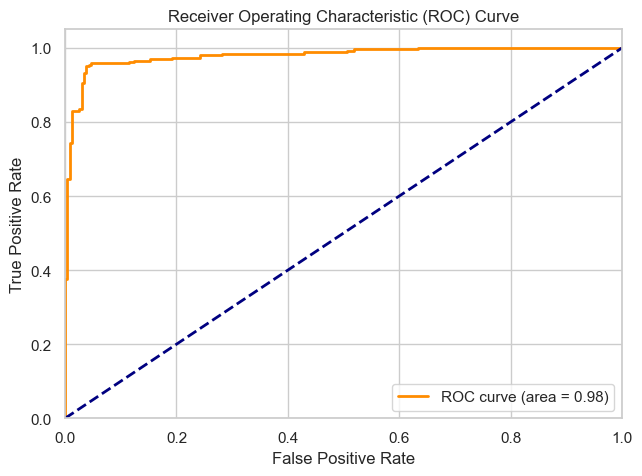

INFO:tensorflow:Assets written to: toxicity_detection_model\assets


INFO:tensorflow:Assets written to: toxicity_detection_model\assets


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import seaborn as sns
from matplotlib.pyplot import style
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid', color_codes=True)

# Load the dataset
df = pd.read_csv('toxic(1).csv')
print("Shape:", df.shape)
print("/n FIRST 10 DATA RECORDS:", df.head(10))
print("/nINFORMATION", df.info())


# Define a function for data cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, punctuation, and numbers using regex
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

# Apply data cleaning to the 'sentence' column
df['sentence'] = df['sentence'].apply(clean_text)

# Tokenize the cleaned sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['sentence'].values)
sequences = tokenizer.texts_to_sequences(df['sentence'].values)

# Pad sequences to ensure uniform length
sequence_length = 100
padded_sequences = pad_sequences(sequences, maxlen=sequence_length, padding='post')

# Adapt the TextVectorization layer with the preprocessed text data
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding token
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(df['sentence'].values)

data = tf.data.Dataset.from_tensor_slices((df['sentence'].values, df['contains_bad_word'].values))

# Plot data distribution
df['contains_bad_word'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xticks([0, 1], ['Non-toxic class', 'Toxic class'], rotation=0)
plt.ylabel('Count')
plt.show()

# Preprocess data
data = data.map(lambda sentence, contains_bad_word: (sentence, tf.cast(contains_bad_word, tf.bool)))
buffer_size = 10000
batch_size = 64

# Split data into train, validation, and test sets
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))  # 10% of data for validation
test_size = len(df) - train_size - val_size  # remaining data for testing

train_data = data.take(train_size).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = data.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = data.skip(train_size + val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build the model
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True,
                                                       kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
                                                       recurrent_regularizer=regularizers.l2(0.001),
                                                       bias_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
                                                       recurrent_regularizer=regularizers.l2(0.001),
                                                       bias_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    tf.keras.layers.Dropout(0.8),  # Dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Train the model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])

# Evaluate the model
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data)

print('Training Loss:', train_loss)
print('Training Accuracy:', train_acc)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

# Define plot_graphs function
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.savefig('plot.png')
plt.show()

# Predict on the test data
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5).astype(int)

# Extract true labels from the test data
y_true = np.concatenate([labels.numpy() for _, labels in test_data])



# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
cm = np.array([[tn, fp], [fn, tp]])
labels = ['Negative', 'Positive']

# Calculate precision, recall, and F1-score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Accuracy:", accuracy)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Calculate F1-score using sklearn.metrics
f1score = f1_score(y_true, y_pred)
print('F1-score:', f1score)
print("Unique values in validation labels:", np.unique(y_true))
print("Unique values in validation predictions:", np.unique(y_pred))

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j]), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


# Plot ROC curve
y_scores = model.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the model
model.save('toxicity_detection_model', save_format='tf', overwrite=True)
